# ERROR Analysis

In [63]:
from mlp_classifier import MLPClassifier
from mlp_dataset import MWEDataset, readfile
from lstm_classifier import MweLSTM
from lstm_dataset import LstmDataset
import mlp_dataset
import os
import matplotlib.pyplot as plt
from mlp_classifier import MLPClassifier
import matplotlib.pyplot as plt
from collections import Counter
import torch
import tqdm
import itertools

In [100]:
mlptrainset = MWEDataset("corpus/surf.ftb.train",  isTrain = True,  window_size = 3)
mlptestset    = MWEDataset("corpus/surf.ftb.test", window_size = 3)

token Vocab size 27472
token Vocab size 27472


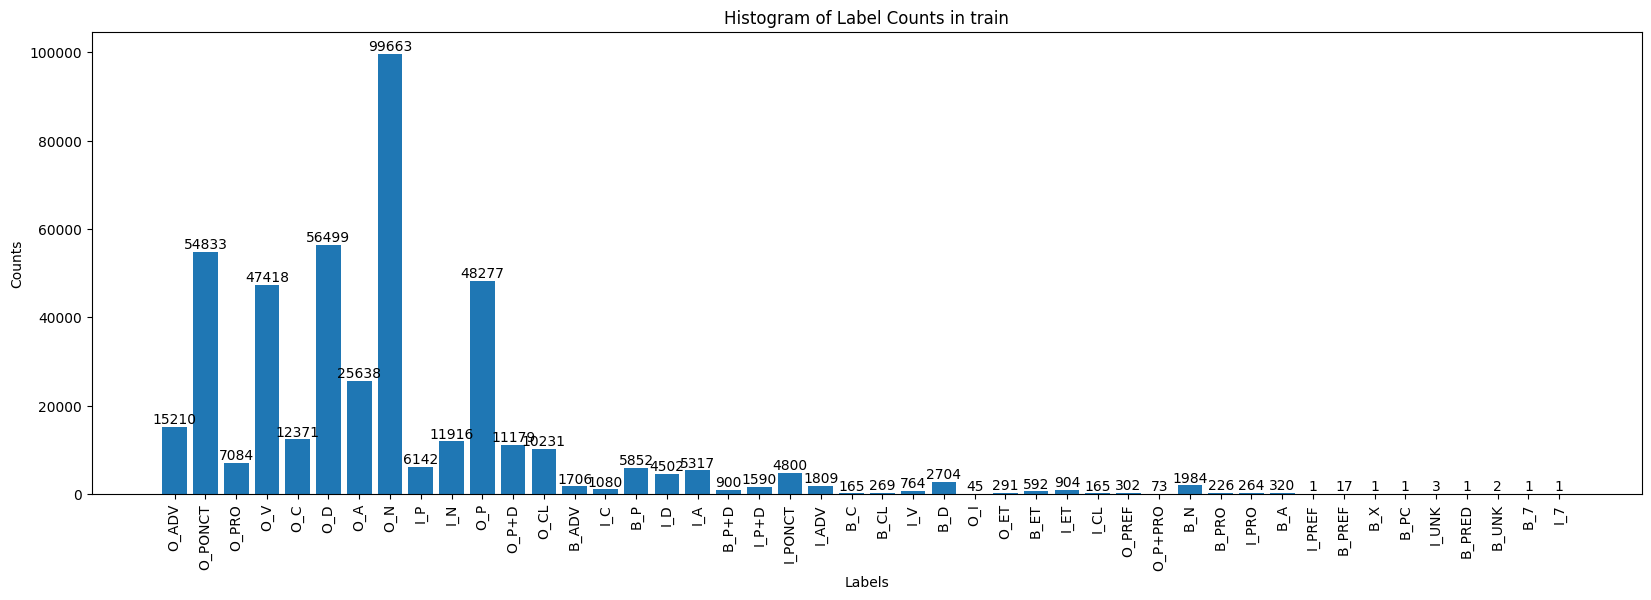

In [32]:
labels, counts = zip(*trainset.tags_dist.items())
plt.figure(figsize=(20, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Histogram of Label Counts in train')
plt.xticks(rotation=90)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

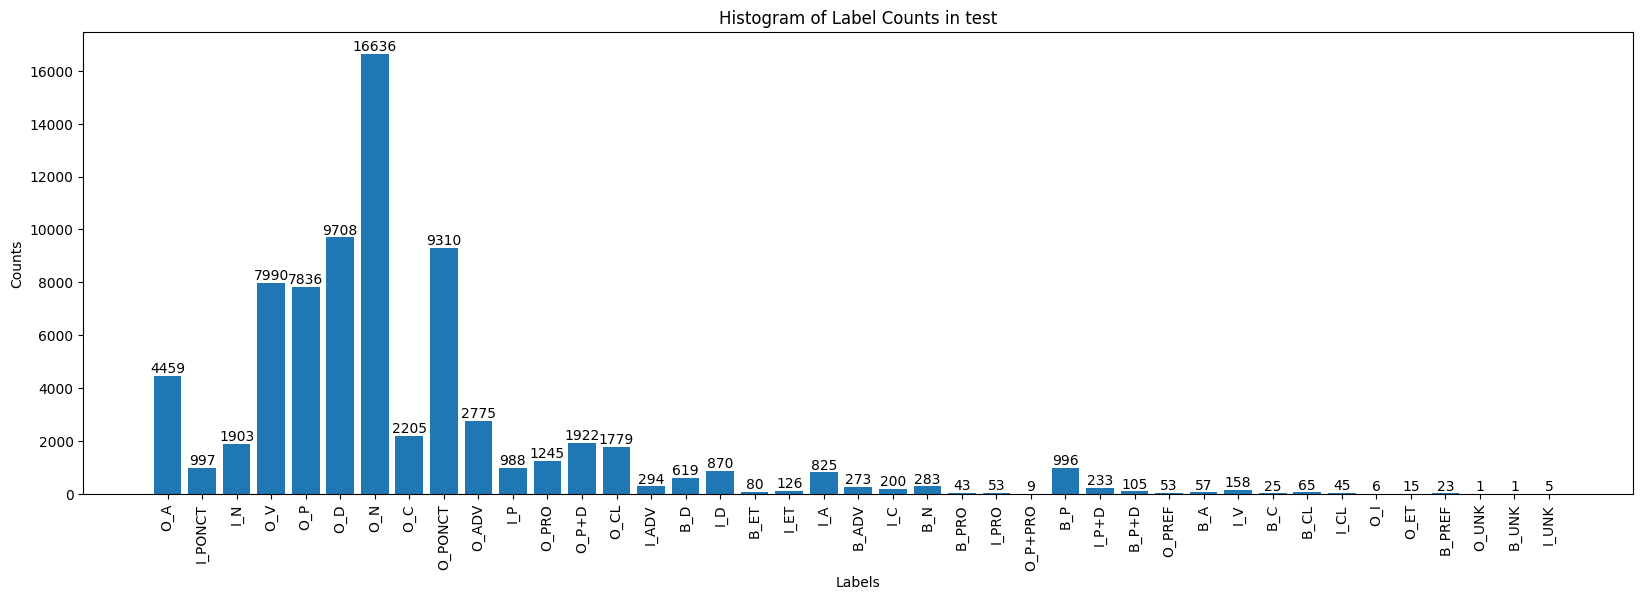

In [33]:
labels, counts = zip(*testset.tags_dist.items())
plt.figure(figsize=(20, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Histogram of Label Counts in test')
plt.xticks(rotation=90)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

# MLP classifier

In [34]:
mod_dir = "trained_models"
mod = "mlp_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags.txt"
mlp, toks_vocab, tags_vocab = MLPClassifier.load(os.path.join(mod_dir, mod),
                                                   os.path.join(mod_dir, toksfile),
                                                   os.path.join(mod_dir, tagsfile), 
                                                   window_size = 3, 
                                                   embsize=200, 
                                                   hidden_size=128, 
                                                   drop_out=0.1, 
                                                   device="cpu")

mlp.to("cpu")
mlp.eval()

MLPClassifier(
  (word_embedding): Embedding(27472, 200)
  (FFW): Linear(in_features=128, out_features=48, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (net): MLP_baseline(
    (net): Sequential(
      (0): Linear(in_features=1400, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): ReLU()
    )
  )
)

In [35]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = mlp.evaluate(testset.get_loader(batch_size = 500))

100%|█████████████████████████████████████████| 151/151 [00:02<00:00, 72.99it/s]


In [17]:
precision = TP/(FP+TP)
recall    = TP/(FN+TP)
f_score   = 2*(precision*recall)/(precision+recall)
nan_mask = torch.isnan(precision)
precision[nan_mask] = 0.
nan_mask = torch.isnan(recall)
recall[nan_mask] = 0.
nan_mask = torch.isnan(f_score)
f_score[nan_mask] = 0.


In [58]:
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_precision, weighted_recall,weighted_f1_score ))

weighted Precision 0.8847 | Recall  0.8884 |  F-score  0.8826   


In [98]:
def mwe_f_score(mod, test_loader):
    """
    a micro f score?
    """
    TN = 0  #outside mwe
    TP = 0  #inside mwe
    FP = 0 #wrongly predicted as mwe
    FN = 0 #not detected mwe
    num_tags = len(mlp.tags_vocab)

    with torch.no_grad():
        for X_toks, Y_golds in (test_loader):
            masks  = (X_toks != mod.toks_vocab["<pad>"])
            logits = mlp.forward(X_toks)
            scores, predicted_IDs = torch.max(logits.data, dim=1)
            predicted_IDs = predicted_IDs.view(-1)
            Y_golds       = Y_golds.view(-1)
            for gold, pred in zip(Y_golds,predicted_IDs):
                gold_tag = mlp.tags_vocab.rev_lookup(int(gold))
                pred_tag = mlp.tags_vocab.rev_lookup(int(pred))
                if gold_tag.startswith("O"): #N
                    if pred_tag.startswith("O"):  #if the pred tag is indeed outside a mwe
                        TN+=1
                    else:
                        FP+=1 
                else:     #P
                    #print(gold_tag, pred_tag)
                    if not pred_tag.startswith("O"): # if the pred tag is indeed inside a mwe
                        TP+= 1
                    else: 
                        FN+=1
    return TN, TP, FP, FN

In [101]:
TN, TP, FP, FN = mwe_f_score(mlp, mlptestset.get_loader(batch_size = 100))

In [102]:
precision = TP/(TP+FP)
recall    = TP/(TP+FN)
f_score   = 2*precision*recall/(precision+recall)

In [103]:
print(f"MWE: Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (precision, recall, f_score))

MWE: Precision 0.8231 | Recall  0.6094 |  F-score  0.7003   


# bi-LSTM-CRF classifier error analysis

In [64]:
trainset = LstmDataset("corpus/surf.ftb.train",  isTrain = True)
testset    = LstmDataset("corpus/surf.ftb.test")

token Vocab size 27472
token Vocab size 27472


In [68]:
mod_dir = "trained_models"
rnn_mod = "lstm_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags.txt"
lstm, toks_vocab, tags_vocab = MweLSTM.load(os.path.join(mod_dir, rnn_mod), 
                                            "LSTM",
                                            os.path.join(mod_dir, toksfile),
                                            os.path.join(mod_dir, tagsfile), 
                                            embsize=200, 
                                            hidden_size=256, 
                                            drop_out=0.1, 
                                            device="cpu")

lstm.to("cpu")
lstm.eval()

MweLSTM(
  (word_embedding): Embedding(27472, 200)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTMmwe(
    (lstm): LSTM(200, 128, batch_first=True, bidirectional=True)
  )
  (crf): CRF(
    (fc): Linear(in_features=256, out_features=50, bias=True)
  )
)

In [5]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = lstm.evaluate(testset.get_loader(batch_size = 100))

100%|███████████████████████████████████████████| 26/26 [00:15<00:00,  1.68it/s]


In [13]:
precision = TP/(FP+TP)
recall    = TP/(FN+TP)
f_score   = 2*(precision*recall)/(precision+recall)
nan_mask = torch.isnan(precision)
precision[nan_mask] = 0.
nan_mask = torch.isnan(recall)
recall[nan_mask] = 0.
nan_mask = torch.isnan(f_score)
f_score[nan_mask] = 0.


In [6]:
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_f1_score, weighted_recall, weighted_precision))

weighted Precision 0.9128 | Recall  0.9154 |  F-score  0.9136   


In [92]:
def mwe_f_score_lstm(mod, test_loader):
    """
    a micro f score?
    """
    TN = 0  #outside mwe
    TP = 0  #inside mwe
    FP = 0 #wrongly predicted as mwe
    FN = 0 #not detected mwe
    num_tags = len(mlp.tags_vocab)

    with torch.no_grad():
        for X_toks, Y_golds in (test_loader):
            masks  = (X_toks != mod.toks_vocab["<pad>"])
            logits = mod.forward(X_toks, masks)
            best_score, best_paths = mod.crf(logits, masks) #viterbi
            best_paths = itertools.chain(*best_paths)
            Y_golds    = [int(tagidx) for tagidx in Y_golds.view(-1) if tagidx!=mod.toks_vocab["<pad>"]]
            for gold, pred in zip(Y_golds,best_paths):
                
                gold_tag = mod.tags_vocab.rev_lookup(int(gold))
                pred_tag = mod.tags_vocab.rev_lookup(int(pred))

                #general eval 
                if gold_tag.startswith("O"): #N
                    if pred_tag.startswith("O"):  #if the pred tag is indeed outside a mwe
                        TN+=1
                    else:
                        FP+=1 
                else:     #P
                    #print(gold_tag, pred_tag)
                    if not pred_tag.startswith("O"): # if the pred tag is indeed inside a mwe
                        TP+= 1
                    else: 
                        FN+=1
                #strict eval
                """
                if gold_tag.startswith("O"): #N
                    if pred_tag == gold_tag:  #if the pred tag is indeed outside a mwe
                        TN+=1
                    else:
                        FP+=1 
                else:     #P
                    #print(gold_tag, pred_tag)
                    if pred_tag == gold_tag: # if the pred tag is indeed inside a mwe
                        TP+= 1
                    else: 
                        FN+=1
                """
                
    return TN, TP, FP, FN

In [93]:
TN, TP, FP, FN = mwe_f_score_lstm(lstm, testset.get_loader(batch_size = 100))

In [94]:
precision = TP/(TP+FP)
recall    = TP/(TP+FN)
f_score   = 2*precision*recall/(precision+recall)

In [95]:
print(f"MWE: Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (precision, recall, f_score))

MWE: Precision 0.8293 | Recall  0.6983 |  F-score  0.7582   


In [105]:
mod_dir = "trained_models"
mod_file= "atlstm_mod.pth"
toksfile= "toks.txt"
tagsfile= "tags.txt"
atlstm, toks_vocab, tags_vocab = MweLSTM.load(os.path.join(mod_dir, mod_file), 
                                              "ATLSTM",
                                              os.path.join(mod_dir, toksfile),
                                              os.path.join(mod_dir, tagsfile), 
                                              embsize=200, 
                                              hidden_size=256, 
                                              drop_out=0.1, 
                                              device="cpu")

atlstm.to("cpu")
atlstm.eval()

MweLSTM(
  (word_embedding): Embedding(27472, 200)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): AttentionLSTM(
    (lstm): LSTM(200, 128, batch_first=True, bidirectional=True)
    (attention): Attention(
      (Wq): Linear(in_features=256, out_features=256, bias=True)
      (Wk): Linear(in_features=256, out_features=256, bias=True)
      (Wv): Linear(in_features=256, out_features=256, bias=True)
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (FFW): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): ReLU()
      )
    )
  )
  (crf): CRF(
    (fc): Linear(in_features=256, out_features=50, bias=True)
  )
)

In [9]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = atlstm.evaluate(testset.get_loader(batch_size = 100))

100%|███████████████████████████████████████████| 26/26 [00:27<00:00,  1.08s/it]


In [10]:
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_f1_score, weighted_recall, weighted_precision))

weighted Precision 0.9177 | Recall  0.9192 |  F-score  0.9185   


In [106]:
TN, TP, FP, FN = mwe_f_score_lstm(atlstm, testset.get_loader(batch_size = 100))

In [107]:
precision = TP/(TP+FP)
recall    = TP/(TP+FN)
f_score   = 2*precision*recall/(precision+recall)

In [108]:
print(f"MWE: Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (precision, recall, f_score))

MWE: Precision 0.8189 | Recall  0.7409 |  F-score  0.7780   


## General stats

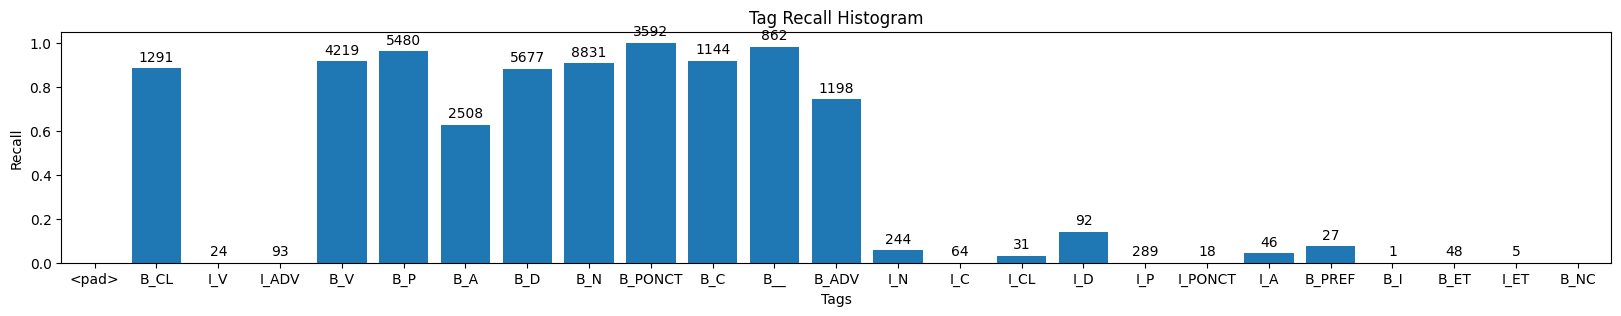

In [7]:

tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, recall)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

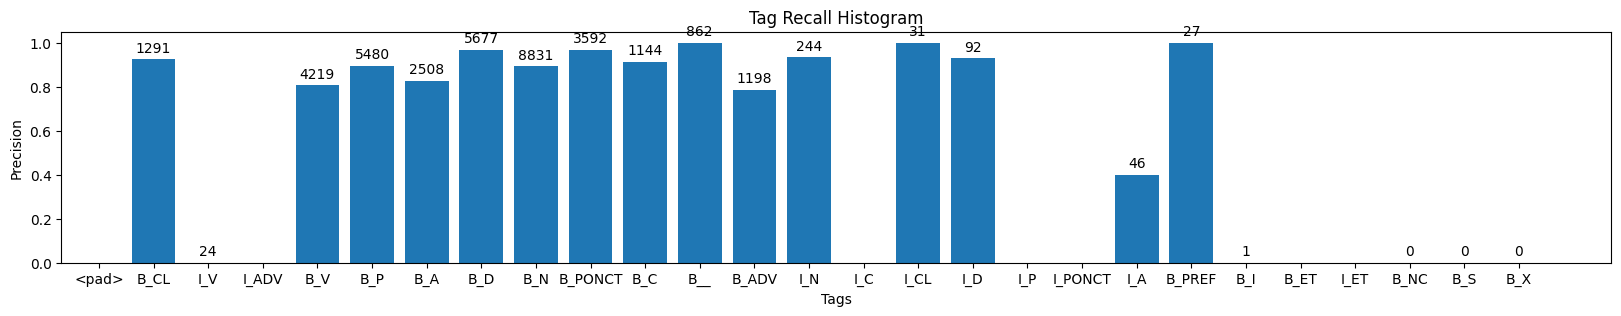

In [8]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, precision)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Precision')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

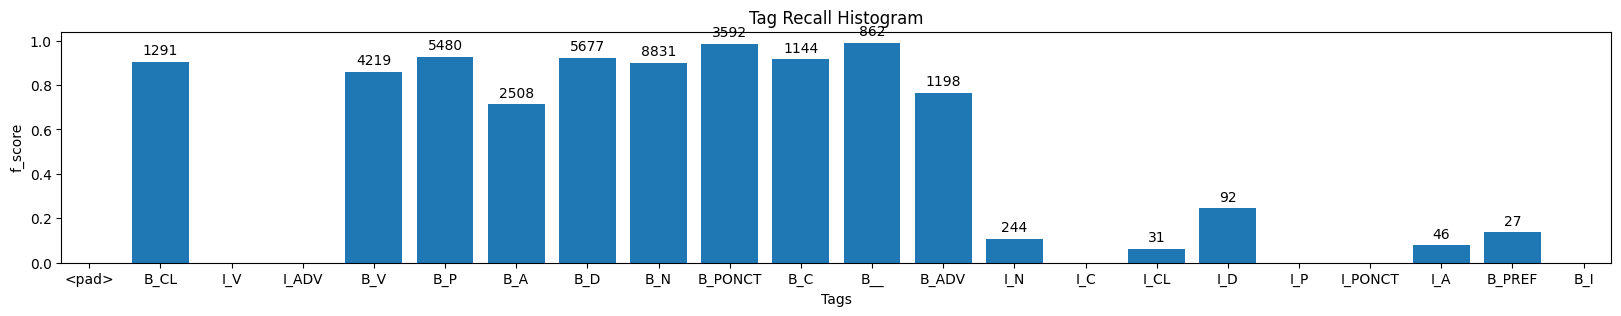

In [9]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, f_score)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('f_score')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

## Analysis per MWE tags (B and I and O)

In [15]:
ex = {"tags":[], "freq": [], "P": [], "R":[], "f": []}
for tag, freq, P, R, f in zip(mlp.tags_vocab.idx2word, class_counts, precision, recall, f_score):
    if tag.startswith("I"):
        print(tag , int(freq), float(P), float(R), float(f))
        ex["freq"].append(freq)
        ex["tags"].append(tag)
        ex["P"].append(float(P))
        ex["R"].append(float(R))
        ex["f"].append(float(f))

NameError: name 'precision' is not defined

In [54]:
2*sum(ex["P"])*sum(ex["R"])/(sum(ex["P"])+sum(ex["R"]))

0.5062459449725133

In [4]:
class_counts, TP, FP, FN, average_precision, average_recall, average_f1_score, weighted_f1_score, weighted_recall, weighted_precision = modelmlp.evaluate(testset.get_loader(batch_size = 500))

100%|███████████████████████████████████████████| 72/72 [00:00<00:00, 83.49it/s]


In [7]:
print("tags-------class count --------recall----------precision---------f-score")
for tag in range(len(modelmlp.tags_vocab)):
    print(f"{modelmlp.tags_vocab.rev_lookup(tag)} %d   | Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (int(class_counts[tag]), float(recall[tag]), float(precision[tag]), float(f_score[tag])))
    print()
print(f"weighted Precision %.4f | Recall  %.4f |  F-score  %.4f   " % (weighted_f1_score, weighted_recall, weighted_precision))

tags-------class count --------recall----------precision---------f-score
<unk> 0   | Precision nan | Recall  nan |  F-score  nan   

<pad> 0   | Precision nan | Recall  nan |  F-score  nan   

B_CL 1291   | Precision 0.8428 | Recall  0.9339 |  F-score  0.8860   

I_V 24   | Precision 0.0000 | Recall  nan |  F-score  nan   

I_ADV 93   | Precision 0.0000 | Recall  nan |  F-score  nan   

B_V 4219   | Precision 0.8483 | Recall  0.9577 |  F-score  0.8997   

B_P 5480   | Precision 0.9624 | Recall  0.8971 |  F-score  0.9286   

B_A 2508   | Precision 0.6423 | Recall  0.8330 |  F-score  0.7253   

B_D 5677   | Precision 0.8804 | Recall  0.9667 |  F-score  0.9215   

B_N 8831   | Precision 0.8906 | Recall  0.8606 |  F-score  0.8753   

B_PONCT 3592   | Precision 0.9944 | Recall  0.9800 |  F-score  0.9871   

B_C 1144   | Precision 0.9344 | Recall  0.8857 |  F-score  0.9094   

B__ 862   | Precision 0.9768 | Recall  0.9953 |  F-score  0.9859   

B_ADV 1198   | Precision 0.7504 | Recall  0.397

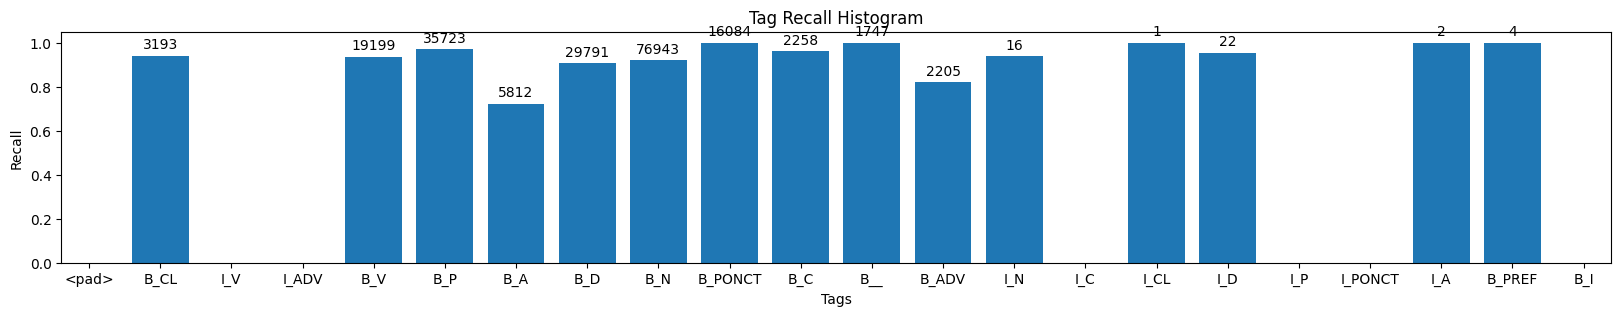

In [58]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, recall)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

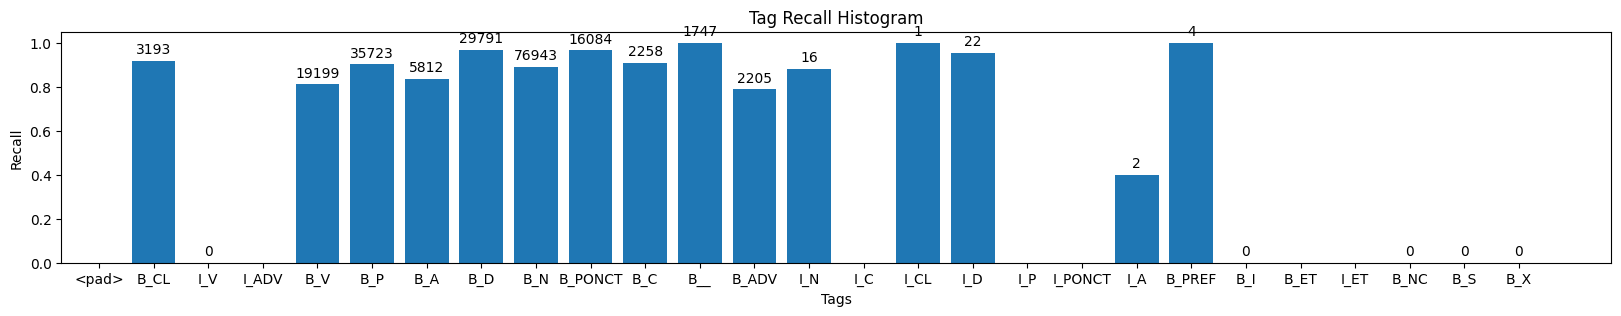

In [59]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, precision)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

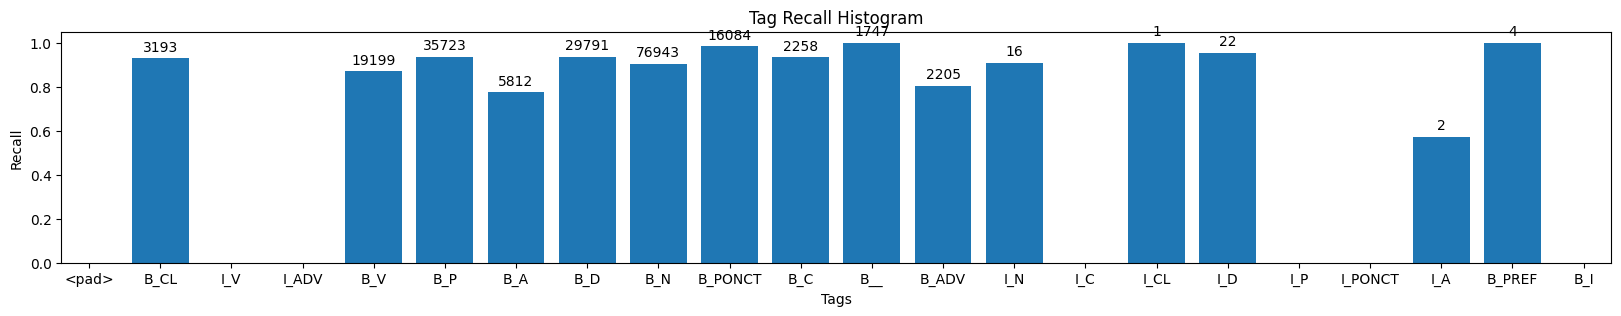

In [60]:
tags = [model.tags_vocab.rev_lookup(tag) for tag in range(len(model.tags_vocab))]

fig, ax = plt.subplots(figsize=(20, 3))  

# Plot the histogram
bars = ax.bar(tags, f_score)

# Add class count annotations on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = int(class_counts[i])
    ax.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Set axis labels and title
ax.set_xlabel('Tags')
ax.set_ylabel('Recall')
ax.set_title('Tag Recall Histogram')

# Display the plot
plt.show()

100%|███████████████████████████████████████████| 26/26 [00:14<00:00,  1.80it/s]
